In [14]:
import torch
torch.cuda.empty_cache()
torch.manual_seed(0)

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2 import HighResDV2
from hr_dv2.high_res import torch_pca

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import label2rgb

from hr_dv2.segment import semantic_segment, cluster

In [15]:
def load_img(path: str) -> tuple[torch.Tensor, np.ndarray]:
    temp_img = Image.open(path)
    h, w = temp_img.height, temp_img.width
    transform = tr.get_input_transform(518,518)
    #transform = tr.closest_crop(h, w, patch_size=14)
    tensor, img = tr.load_image(path, transform)
    H, W = img.height, img.width
    return tensor, np.array(img)

In [16]:
net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.interpolation_mode = 'nearest-exact'
net.cuda()

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


HighResDV2(
  (dinov2): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(4, 4))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
     

In [17]:

tensor, img_arr = load_img('fig_data/sofc.jpg')
H, W, C = img_arr.shape
tensor = tensor.cuda()
out = [img_arr]
attn_arrs = [img_arr]


for i in range(3):
    if i == 0:
        fwd, inv = [], []
    elif i == 1:
        fwd, inv = tr.get_shift_transforms([1, 2,], 'Moore')
    elif i == 2:
        fwd_shift, inv_shift = tr.get_shift_transforms([1, 2,], 'Moore')
        fwd_flip, inv_flip = tr.get_flip_transforms()
        fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
    net.set_transforms(fwd, inv)

    feats_attn_tensor = net.forward(tensor, attn_choice="o")
    feats, attn = feats_attn_tensor[0, :-6, :, :], feats_attn_tensor[0, -6:, :, :]
    pcaed = torch_pca(feats, 3, max_samples=80000)

    pcaed = tr.to_numpy(pcaed)
    rescaled = rescale_pca(pcaed)
    attn_np = tr.to_numpy(attn, False)

    out.append(rescaled)
    attn_arrs.append(attn_np)



In [18]:
for i in range(2, 4):
    inp = out[i]
    labels, centers = cluster(inp, 80)
    seg, _ = semantic_segment(inp, attn_arrs[i], labels, centers, img_arr)
    print(seg.shape)
    out.append(seg)

(268324, 3) (268324, 3, 1) (1, 3, 6)
(518, 518)
(268324, 3) (268324, 3, 1) (1, 3, 6)
(518, 518)


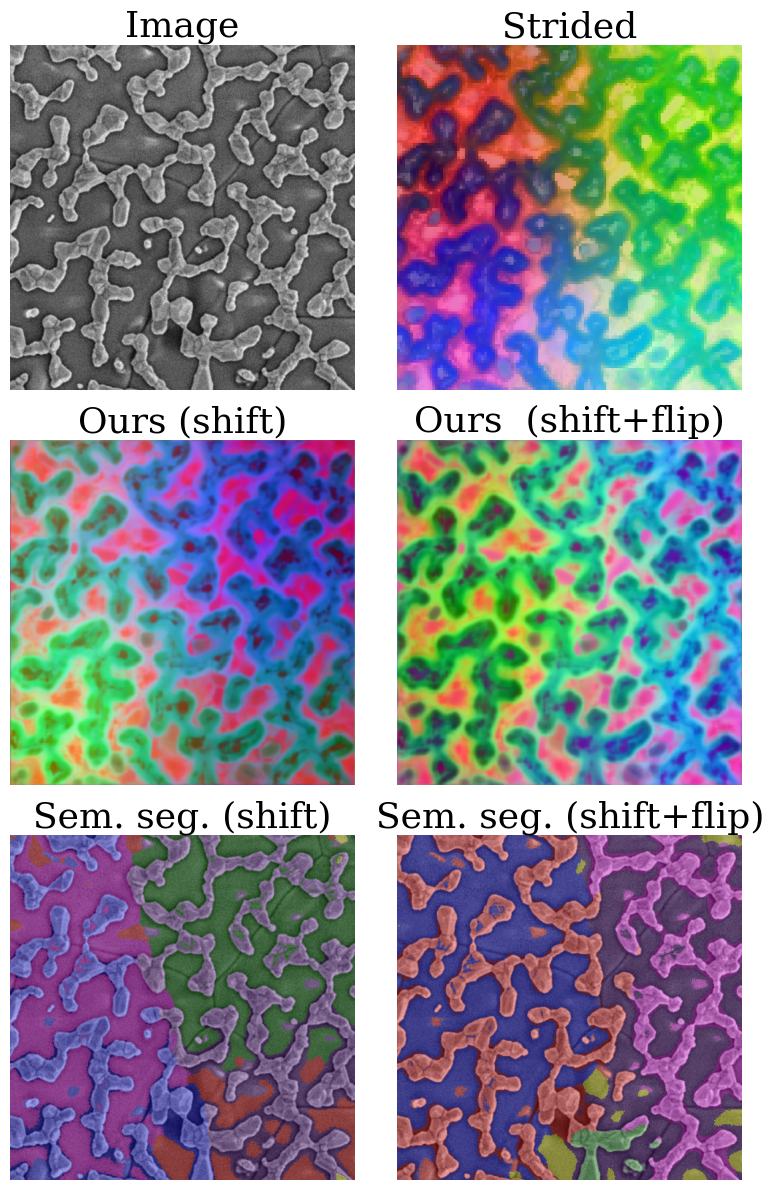

In [19]:
fig, axs = plt.subplots(3, 2)

fig.set_size_inches(8, 12)
plt.rcParams["font.family"] = "serif"
titles = ["Image", "Strided", "Ours (shift)", "Ours  (shift+flip)", "Sem. seg. (shift)", "Sem. seg. (shift+flip)"]

for i in range(6):
    data = out[i]

    if i > 3:
        data = label2rgb(data, img_arr, bg_label=-1)

    img = data.reshape((H, W, 3))


    ax = axs[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=26)
    ax.set_axis_off()
plt.tight_layout()
plt.savefig('fig_out/positional_effects.png')